In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import itertools

import numpy as np
import scipy as sp
import pandas as pd
import gudhi as gh
import networkx as nx

from scipy import stats
from scipy.spatial.distance import cdist

from matplotlib import pyplot as plt

from src.depth import DepthPoset
from src.drow import plot_filtred_complex2d, plot_simplex, enumerate_points

from tqdm.notebook import tqdm

# Define SImplicial Trees and Depth Posets

In [3]:
def get_random_reordered_stree(stree, change=1.):
    order = np.array([simplex for simplex, value in stree.get_filtration()], dtype=object)
    dims = np.array([len(s) for s in order])
    new_order = []
    for dim in np.unique(dims):
        order_dim = order[dims == dim]
        old_index_change = np.random.choice(np.arange(len(order_dim)), int(change*len(order_dim)), replace=False)
        new_index_change = np.random.choice(old_index_change, len(old_index_change), replace=False)
        order_dim[old_index_change] = order_dim[new_index_change]
        new_order.extend(order_dim)
        
    new_stree = gh.SimplexTree()
    for value, simplex in enumerate(new_order):
        new_stree.insert(simplex, value)
    return new_stree

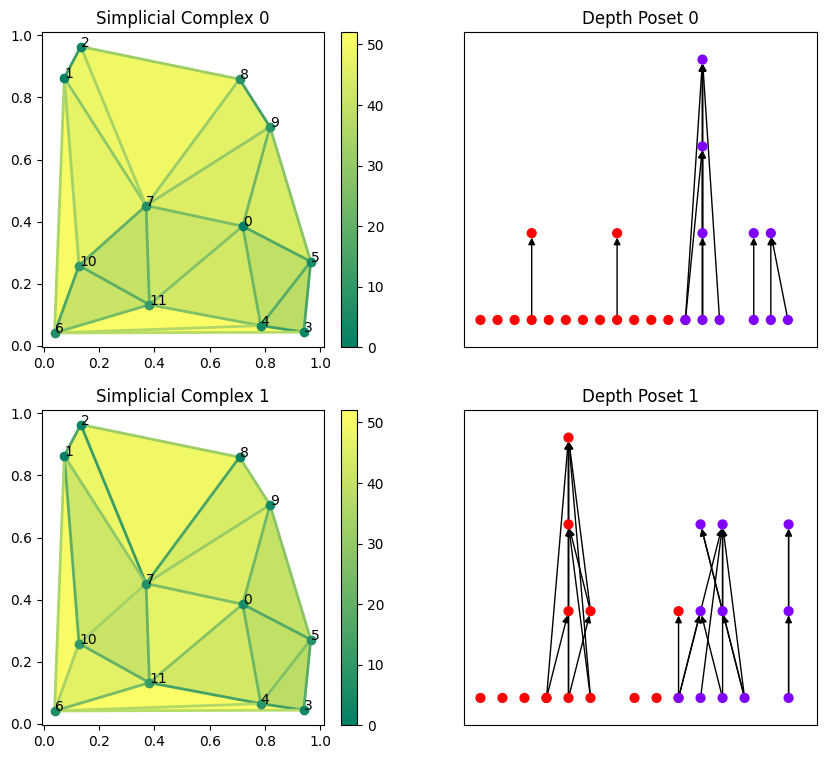

In [4]:
n = 12
dim = 2
points = np.random.random([n, dim])

stree = gh.AlphaComplex(points).create_simplex_tree()
order = []
for d in range(dim + 1):
    for simplex, value in stree.get_filtration():
        if len(simplex) == d + 1:
            order.append(simplex)
stree0 = gh.SimplexTree()
for value, simplex in enumerate(order):
    stree0.insert(simplex, value)

dp0 = DepthPoset.from_simplex_tree(stree0)


stree1 = get_random_reordered_stree(stree0, change=0.5)
dp1 = DepthPoset.from_simplex_tree(stree1)

fig, axs = plt.subplots(2, 2, figsize=(10, 9))

for i, (stree, dp) in enumerate(zip([stree0, stree1], [dp0, dp1])):
    axs[i, 0].set_title(f'Simplicial Complex {i}')
    sm = plot_filtred_complex2d(stree, points, cmap='summer', ax=axs[i, 0])
    plt.colorbar(sm, ax=axs[i, 0])
    enumerate_points(points, ax=axs[i, 0])
    
    axs[i, 1].set_title(f'Depth Poset {i}')
    cmap = plt.get_cmap('rainbow')
    node_colors = [cmap(node.dim/(dim - 1)) for node in dp0.nodes]
    nx.draw_networkx(dp.get_transitive_closure(), dp.hasse_layout(), 
                     node_color=node_colors, node_size=40, with_labels=False,
                     ax=axs[i, 1])

plt.show()

In [5]:
df_filtrations = pd.DataFrame({'Complex 0': {str(key): value for key, value in stree0.get_filtration()}, 
                               'Complex 1': {str(key): value for key, value in stree1.get_filtration()}})
#df_filtrations[df_filtrations['Complex 0'] != df_filtrations['Complex 1']]
pd.Series({ord: np.linalg.norm(df_filtrations['Complex 1'] - df_filtrations['Complex 0'], ord=ord) for ord in [0, np.inf]})

0.0    23.0
inf    22.0
dtype: float64

# Depth Poset Difference Scores

## Special Scores

In [6]:
def jacard_index(a, b):
    """
    Calculate the Jaccard index
    """
    intersection = set(a) & set(b)
    union = set(a) | set(b)
    if len(union) == 0:
        return 1.0
    return len(intersection) / len(union)

In [7]:
def hausdorff_distance(x, y, metric='euclidean') -> float:
    """
    The Hausdorf Distance between 2 sets

    Parameters:
    -----------
    x: np.ndarray shape (n0, d)
    
    y: np.ndarray shape (n1, d)
    """
    x = np.asarray(x)
    y = np.asarray(y)

    dist_matrix = sp.spatial.distance.cdist(x, y, metric=metric)

    return max(dist_matrix.min(axis=1).max(), dist_matrix.min(axis=0).max())


## Comparing Cells

In [8]:
def jacard_cells(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of cells sets represented in 2 Depth Posets.
    """
    cells0 = [node.source[0] for node in dp0.nodes] + [node.source[1] for node in dp0.nodes]
    cells1 = [node.source[0] for node in dp1.nodes] + [node.source[1] for node in dp1.nodes]
    return jacard_index(cells0, cells1)

In [9]:
jacard_cells(dp0, dp1)

0.9622641509433962

In [10]:
def jacard_nodes_cells(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of nodes sources sets of 2 Depth Posets.
    """
    return jacard_index([node.source for node in dp0.nodes], [node.source for node in dp1.nodes])

In [11]:
jacard_nodes_cells(dp0, dp1)

0.18181818181818182

In [12]:
def jacard_edges_cells(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of nodes sources sets of 2 Depth Posets.
    """
    return jacard_index([(node0.source, node1.source) for node0, node1 in dp0.edges], 
                        [(node0.source, node1.source) for node0, node1 in dp1.edges])
    

In [13]:
jacard_edges_cells(dp0, dp1)

0.0

## Comparing Index

In [14]:
def jacard_nodes_bd_index(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of birth-death indices sets represented in 2 Depth Posets.
    """
    bd0 = [(node.birth_index, node.death_index) for node in dp0.nodes]
    bd1 = [(node.birth_index, node.death_index) for node in dp1.nodes]
    return jacard_index(bd0, bd1)

In [15]:
jacard_nodes_bd_index(dp0, dp1)

0.13043478260869565

In [16]:
def jacard_edges_bd_index(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of edge pairs of birth-death indices sets represented in 2 Depth Posets.
    """
    e_bd0 = [(node0.birth_index, node0.death_index, node1.birth_index, node1.death_index) for node0, node1 in dp0.edges]
    e_bd1 = [(node0.birth_index, node0.death_index, node1.birth_index, node1.death_index) for node0, node1 in dp1.edges]
    
    return jacard_index(e_bd0, e_bd1)

In [17]:
jacard_edges_bd_index(dp0, dp1)

0.0

In [18]:
def hausdorff_nodes_bd_index(dp0: DepthPoset, dp1: DepthPoset, metric='euclidean'):
    """
    The Hausdorff distance between birth-death indices sets represented in 2 Depth Posets.
    """
    bd0 = [(node.birth_index, node.death_index) for node in dp0.nodes]
    bd1 = [(node.birth_index, node.death_index) for node in dp1.nodes]
    return hausdorff_distance(bd0, bd1, metric=metric)

In [19]:
hausdorff_nodes_bd_index(dp0, dp1)

np.float64(7.0710678118654755)

In [20]:
def hausdorff_edges_bd_index(dp0: DepthPoset, dp1: DepthPoset, metric='euclidean'):
    """
    The Hausdorff distance between edge pairs of birth-death indices sets represented in 2 Depth Posets.
    """
    e_bd0 = np.array([(node0.birth_index, node0.death_index, node1.birth_index, node1.death_index) for node0, node1 in dp0.edges])
    e_bd1 = np.array([(node0.birth_index, node0.death_index, node1.birth_index, node1.death_index) for node0, node1 in dp1.edges])
    
    return hausdorff_distance(e_bd0, e_bd1, metric=metric)

In [21]:
hausdorff_edges_bd_index(dp0, dp1)

np.float64(9.746794344808963)

## Comparing Values

In [22]:
def jacard_nodes_bd_values(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of birth-death values sets represented in 2 Depth Posets.
    """
    bd0 = [(node.birth_value, node.death_value) for node in dp0.nodes]
    bd1 = [(node.birth_value, node.death_value) for node in dp1.nodes]
    return jacard_index(bd0, bd1)

In [23]:
jacard_nodes_bd_values(dp0, dp1)

0.13043478260869565

In [24]:
def jacard_edges_bd_values(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of edge pairs of birth-death indices sets represented in 2 Depth Posets.
    """
    e_bd0 = [(node0.birth_value, node0.death_value, node1.birth_value, node1.death_value) for node0, node1 in dp0.edges]
    e_bd1 = [(node0.birth_value, node0.death_value, node1.birth_value, node1.death_value) for node0, node1 in dp1.edges]
    
    return jacard_index(e_bd0, e_bd1)

In [25]:
jacard_edges_bd_values(dp0, dp1)

0.0

In [26]:
def hausdorff_nodes_bd_values(dp0: DepthPoset, dp1: DepthPoset, metric='euclidean'):
    """
    The Hausdorff distance between birth-death indices sets represented in 2 Depth Posets.
    """
    bd0 = [(node.birth_value, node.death_value) for node in dp0.nodes]
    bd1 = [(node.birth_value, node.death_value) for node in dp1.nodes]
    return hausdorff_distance(bd0, bd1, metric=metric)

In [27]:
hausdorff_nodes_bd_values(dp0, dp1)

np.float64(7.0710678118654755)

In [28]:
def hausdorff_edges_bd_values(dp0: DepthPoset, dp1: DepthPoset, metric='euclidean'):
    """
    The Hausdorff distance between edge pairs of birth-death indices sets represented in 2 Depth Posets.
    """
    e_bd0 = np.array([(node0.birth_value, node0.death_value, node1.birth_value, node1.death_value) for node0, node1 in dp0.edges])
    e_bd1 = np.array([(node0.birth_value, node0.death_value, node1.birth_value, node1.death_value) for node0, node1 in dp1.edges])
    
    return hausdorff_distance(e_bd0, e_bd1, metric=metric)

In [29]:
hausdorff_edges_bd_values(dp0, dp1)

np.float64(9.746794344808963)

## Density Distance

In [30]:
from src.density import TriangulationDensity

In [31]:
def get_dp_density(dp: DepthPoset, edge_radius_dict):
    # 
    pos = dp.persistant_layout()
    edge_densities = []
    for edge in dp.edges:
        p0 = np.array(pos[edge[0]])
        p1 = np.array(pos[edge[1]])
        r = edge_radius_dict[edge]

        if r > 0:
            vertices = np.array([p0 + np.array([r, -r]), p0 + np.array([r, r]), p0 + np.array([-r, -r]), 
                                 p1 + np.array([-r, r]), p1 + np.array([-r, -r]), p1 + np.array([r, r])])
            triangles = np.array([[0, 1, 2], [3, 4, 5], [1, 2, 5], [2, 4, 5]])
            values = np.ones(4)
        else:
            vertices = np.array([[1, 0], [0.5, 0], [1, 0.5]])
            triangles = np.array([[0, 1, 2]])
            values = np.zeros(1)

        edge_densities.append(TriangulationDensity(vertices, triangles, values, 0))

    if len(edge_densities) == 0:
        result_density = TriangulationDensity([[1, 0], [0.5, 0], [1, 0.5]], [[0, 1, 2]], [0], 0)
    else: 
        result_density = edge_densities[0]
    for i in range(1, len(edge_densities)):
        result_density = result_density + edge_densities[i]
    return result_density

In [32]:
def get_simplex_neighbours(stree: gh.SimplexTree, simplex):
    # 
    faces = [tuple(simplex) for simplex, _ in stree.get_boundaries(simplex)]
    cofaces_of_faces = []
    for face in faces:
        cofaces_of_faces += [tuple(simplex) for simplex, _ in stree.get_cofaces(face, 1)]
    
    cofaces = [tuple(simplex) for simplex, _ in stree.get_cofaces(simplex, 1)]
    faces_of_cofaces = []
    for coface in cofaces:
        faces_of_cofaces += [tuple(simplex) for simplex, _ in stree.get_boundaries(coface)]
    
    return list(set(cofaces_of_faces + faces_of_cofaces))

In [33]:
simplex = [s for s, v in stree.get_simplices()]
simplex = simplex[np.random.randint(len(simplex))]
simplex               

[0, 7, 9]

In [34]:
get_simplex_neighbours(stree, simplex)

[(0, 5, 9), (7, 8, 9), (0, 7, 9), (0, 7, 11)]

In [35]:
def get_simplex_neighbours_filtrations(stree: gh.SimplexTree, simplex):
    #
    return [stree.filtration(neighbour) for neighbour in get_simplex_neighbours(stree, simplex)]

In [36]:
get_simplex_neighbours_filtrations(stree, simplex)

[40.0, 44.0, 45.0, 47.0]

In [37]:
def get_edge_radius_dict(stree: gh.SimplexTree, nodes=None):
    # 
    simplex_neighbours_filtrations_dict = {tuple(simplex): get_simplex_neighbours_filtrations(stree, simplex) for simplex, _ in stree.get_simplices()}

    if nodes is None:
        cond = lambda s0, s1, s2, s3: (len(s1) - len(s0) == 1) and (len(s3) - len(s2) == 1) and (len(s0) == len(s2))
        get_arg = lambda s0, s1, s2, s3: ((s0, s1), (s2, s3))
    else:
        source_list = [node.source for node in nodes]
        cond = lambda s0, s1, s2, s3: ((s0, s1) in source_list) and ((s2, s3) in source_list)
        get_arg = lambda s0, s1, s2, s3: ([node for node in nodes if node.source == (s0, s1)][0], 
                                          [node for node in nodes if node.source == (s2, s3)][0])
        
    edge_radius_dict = {}
    for s0, s1, s2, s3 in itertools.product(simplex_neighbours_filtrations_dict.keys(), repeat=4):
        if cond(s0, s1, s2, s3):
            arr0 = np.concatenate([simplex_neighbours_filtrations_dict[s0], 
                                   simplex_neighbours_filtrations_dict[s1]])
            arr1 = np.concatenate([simplex_neighbours_filtrations_dict[s2], 
                                   simplex_neighbours_filtrations_dict[s3]])
            value = cdist(arr0.reshape(-1, 1), arr1.reshape(-1, 1)).min()
            edge_radius_dict.update({get_arg(s0, s1, s2, s3): value})
    return edge_radius_dict

In [38]:
edge_radius_dict = get_edge_radius_dict(stree0)
edge_radius_dict = pd.Series(edge_radius_dict)

edge_radius_dict

((0, 4), (0, 4, 5))  ((0, 4), (0, 4, 5))     0.0
                     ((0, 4), (0, 4, 11))    0.0
                     ((0, 4), (0, 5, 9))     0.0
                     ((0, 4), (0, 7, 9))     0.0
                     ((0, 4), (0, 7, 11))    0.0
                                            ... 
((11,), (10, 11))    ((11,), (7, 9))         0.0
                     ((11,), (7, 10))        0.0
                     ((11,), (7, 11))        0.0
                     ((11,), (8, 9))         0.0
                     ((11,), (10, 11))       0.0
Length: 249444, dtype: float64

In [39]:
edge_radius_dict.value_counts()

0.0    231220
1.0     18040
2.0       160
3.0        24
Name: count, dtype: int64

In [40]:
edge_radius_dict = get_edge_radius_dict(stree0, dp0.nodes)
edge_radius_dict_series = pd.Series(edge_radius_dict)

edge_radius_dict_series.value_counts()

0.0    560
1.0    114
2.0      2
Name: count, dtype: int64

In [41]:
edge_radius_dict_series[dp0.edges]

(2,7),(1,2,7)    (2,8),(2,7,8)      0.0
(0,11),(0,7,11)  (4,11),(0,4,11)    0.0
11,(10,11)       6,(0,7)            0.0
6,(0,7)          1,(1,7)            0.0
10,(6,10)        7,(7,10)           0.0
7,(7,10)         6,(0,7)            0.0
9,(8,9)          8,(0,9)            0.0
5,(3,5)          3,(0,5)            0.0
4,(3,4)          3,(0,5)            0.0
2,(1,2)          1,(1,7)            0.0
dtype: float64

/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:228: RuntimeWarning: invalid value encountered in divide
  t = d0_cross_d2 / d1_cross_d2
/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:229: RuntimeWarning: invalid value encountered in divide
  u = cross(b0 - a0, d1) / d1_cross_d2


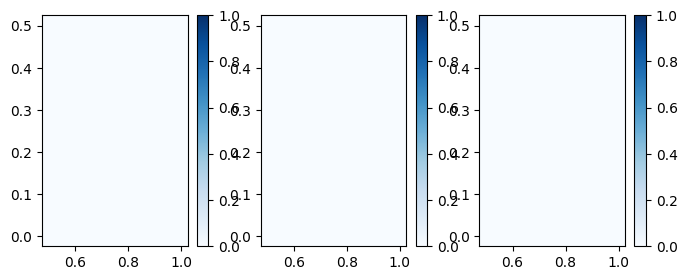

In [42]:
edge_radius_dict0 = get_edge_radius_dict(stree0, dp0.nodes)
edge_radius_dict1 = get_edge_radius_dict(stree1, dp1.nodes)

dens0 = get_dp_density(dp0, edge_radius_dict0)
dens1 = get_dp_density(dp1, edge_radius_dict1)

dens_abs = abs(dens0 - dens1)

fig, axs = plt.subplots(1, 3, figsize=(8, 3))

sm = dens0.show(ax=axs[0])
plt.colorbar(sm, ax=axs[0])

sm = dens1.show(ax=axs[1])
plt.colorbar(sm, ax=axs[1])

sm = dens_abs.show(ax=axs[2])
plt.colorbar(sm, ax=axs[2])

In [43]:
def density_distance(stree0: gh.SimplexTree, stree1: gh.SimplexTree, dp0=None, dp1=None):
    """
    """
    if dp0 is None:
        dp0 = DepthPoset.from_simplex_tree(stree0)
    if dp1 is None:
        dp1 = DepthPoset.from_simplex_tree(stree1)

    edge_radius_dict0 = get_edge_radius_dict(stree0, dp0.nodes)
    edge_radius_dict1 = get_edge_radius_dict(stree1, dp1.nodes)

    dens0 = get_dp_density(dp0, edge_radius_dict0)
    dens1 = get_dp_density(dp1, edge_radius_dict1)

    dens_abs = abs(dens0 - dens1)
    return dens_abs.integral()

In [44]:
density_distance(stree0, stree1, dp0, dp1)

/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:228: RuntimeWarning: divide by zero encountered in divide
  t = d0_cross_d2 / d1_cross_d2
/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:229: RuntimeWarning: divide by zero encountered in divide
  u = cross(b0 - a0, d1) / d1_cross_d2


np.float64(0.0)

# Set of Filtrations on 1 Complex

## Random Model Description and Generating

### Set Parameters

In [45]:
n_filtrations = 8
scale = 0.01
p = 0.1

n = 8
dim = 2
points = np.random.random([n, dim])

stree = gh.AlphaComplex(points).create_simplex_tree()

### Model Description

In [46]:
model_description = f'''
\\par For the given simplicial complex, defined by Delaunay triangulation of $n = {n}$ points uniformly distributed in $[0, 1]^{{{dim}}}$
we define the original filtration in the way:
$$
f(s) - \\dim(s) + x, \\; \\text{{where}}\\; x\\sim \\mathcal{{U}}[0, 1]
$$
\\par Then we are defining $n_f = {n_filtrations}$ filtrations as series, 
s.t. for each $i$-th filtration and simplex $s$ we define the $i+1$-th filtration by adding normal distributed value with scale {scale}:
$$
f_{{i+1}}(s) = 
\\begin{{cases}}
f_i(s) + x\\sim \\mathcal{{N}}(0, {scale}), \\; \\text{{if}} \\; p < {p} \\\\
f_i(s), \\;  \\text{{if}} \\; p \\geq {p} 
\\end{{cases}}, \\; p\\sim \\mathcal{{U}}[0, 1]
$$
and then we normolize each filtration for each dimension:
$$
f_i^{{norm}}(s) = \\cfrac
{{f_i(s) - \\min\\limits_{{\\dim(s) = \\dim(\\sigma)}}f_i(\\sigma)}}
{{\\max\\limits_{{\\dim(s) = \\dim(\\sigma)}}f_i(\\sigma) - \\min\\limits_{{\\dim(s) = \\dim(\\sigma)}}f_i(\\sigma)}} + \\dim(s)
$$

'''.strip()

print(model_description)

\par For the given simplicial complex, defined by Delaunay triangulation of $n = 8$ points uniformly distributed in $[0, 1]^{2}$
we define the original filtration in the way:
$$
f(s) - \dim(s) + x, \; \text{where}\; x\sim \mathcal{U}[0, 1]
$$
\par Then we are defining $n_f = 8$ filtrations as series, 
s.t. for each $i$-th filtration and simplex $s$ we define the $i+1$-th filtration by adding normal distributed value with scale 0.01:
$$
f_{i+1}(s) = 
\begin{cases}
f_i(s) + x\sim \mathcal{N}(0, 0.01), \; \text{if} \; p < 0.1 \\
f_i(s), \;  \text{if} \; p \geq 0.1 
\end{cases}, \; p\sim \mathcal{U}[0, 1]
$$
and then we normolize each filtration for each dimension:
$$
f_i^{norm}(s) = \cfrac
{f_i(s) - \min\limits_{\dim(s) = \dim(\sigma)}f_i(\sigma)}
{\max\limits_{\dim(s) = \dim(\sigma)}f_i(\sigma) - \min\limits_{\dim(s) = \dim(\sigma)}f_i(\sigma)} + \dim(s)
$$


\par For the given simplicial complex, defined by Delaunay triangulation of $n = 8$ points uniformly distributed in $[0, 1]^{2}$
we define the original filtration in the way:
$$
f(s) - \dim(s) + x, \; \text{where}\; x\sim \mathcal{U}[0, 1]
$$
\par Then we are defining $n_f = 20$ filtrations as series, 
s.t. for each $i$-th filtration and simplex $s$ we define the $i+1$-th filtration by adding normal distributed value with scale 0.01:
$$
f_{i+1}(s) = 
\begin{cases}
f_i(s) + x\sim \mathcal{N}(0, 0.01), \; \text{if} \; p < 0.2 \\
f_i(s), \;  \text{if} \; p \geq 0.2 
\end{cases}, \; p\sim \mathcal{U}[0, 1]
$$
and then we normolize each filtration for each dimension:
$$
f_i^{norm}(s) = \cfrac
{f_i(s) - \min\limits_{\dim(s) = \dim(\sigma)}f_i(\sigma)}
{\max\limits_{\dim(s) = \dim(\sigma)}f_i(\sigma) - \min\limits_{\dim(s) = \dim(\sigma)}f_i(\sigma)} + \dim(s)
$$

### Generate Filtrations by the Model

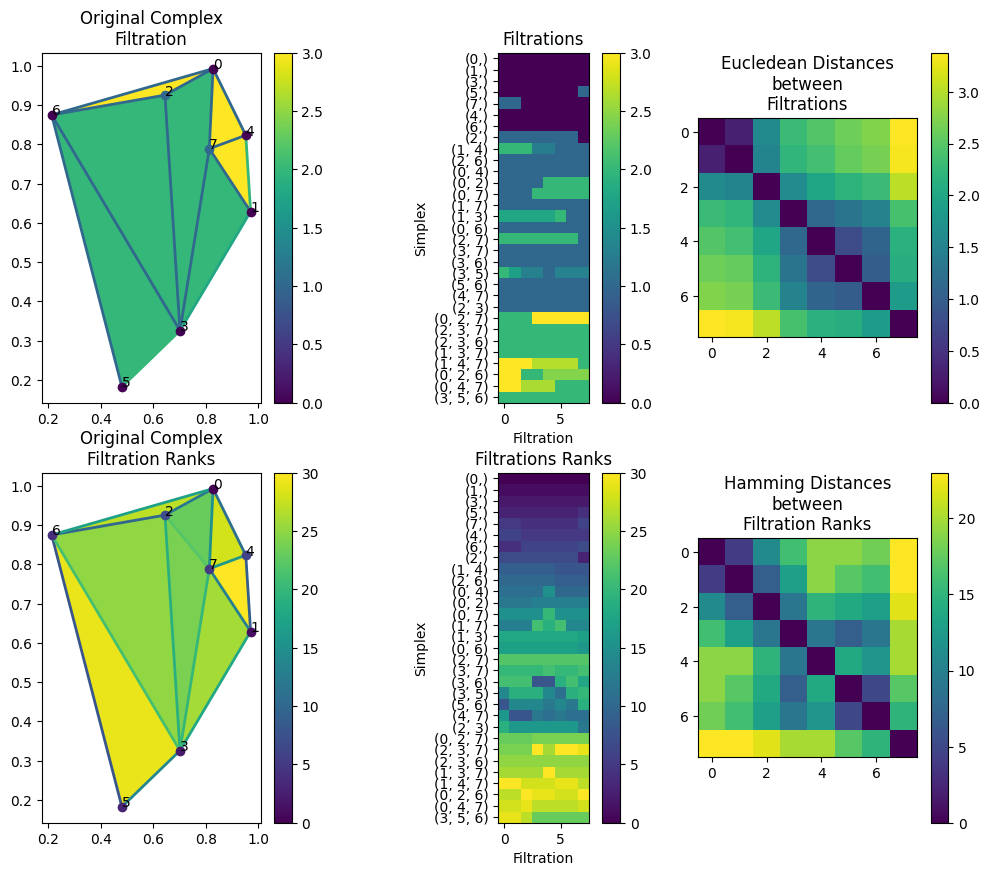

In [47]:
# get simplices and dimensions arrays
simplices = np.array([tuple(s) for s, f_val in stree.get_simplices()], dtype=object)

simplices_dimensions = np.array([len(s) - 1 for s in simplices])
simplices = simplices[simplices_dimensions.argsort()]
simplices_dimensions = np.array([len(s) - 1 for s in simplices])

# generate original filtration
filtrations = np.random.random(len(simplices)) * np.ones([n_filtrations, len(simplices)])

# generate cumulatative normal adding part
filtrations_add = np.random.normal(scale=scale, size=[n_filtrations, len(simplices)])
filtrations_add[0] = 0
filtrations_add[np.random.random(filtrations_add.shape) > p] = 0
filtrations_add = np.cumsum(filtrations_add, axis=0)

# get next filtrations
filtrations = filtrations + filtrations_add
divider = filtrations.max(axis=0) - filtrations.min(axis=0)
divider[divider == 0] = 1
filtrations = (filtrations - filtrations.min(axis=0)) / divider
for d in range(dim + 1):
    filtrations[:, simplices_dimensions == d] += d

# get filtrations_rank
filtrations_rank = filtrations.argsort(axis=1)

# find distances between filtrations
filtrations_distances = cdist(filtrations, filtrations, metric='euclidean')
filtrations_rank_distances = cdist(filtrations_rank, filtrations_rank, metric='hamming')*len(simplices)

# define coresponding simplicial complexes
stree_original = gh.SimplexTree()
for simplex, value in zip(simplices, filtrations[0]):
    stree_original.insert(simplex, value)
stree_original_ranked = gh.SimplexTree()
for simplex, value in zip(simplices, filtrations_rank[0]):
    stree_original_ranked.insert(simplex, value)


# 
fig, axs = plt.subplots(2, 3, figsize=(12, 10))

axs[0, 0].set_title('Original Complex\nFiltration')
sm = plot_filtred_complex2d(stree_original, points, ax=axs[0, 0], cmap='viridis', vmin=0, vmax=dim+1)
plt.colorbar(sm, ax=axs[0, 0])
enumerate_points(points, ax=axs[0, 0])

axs[0, 1].set_title('Filtrations')
sm = axs[0, 1].imshow(filtrations.transpose(), vmin=0, vmax=dim+1)
plt.colorbar(sm, ax=axs[0, 1])
axs[0, 1].set_ylabel('Simplex')
axs[0, 1].set_xlabel('Filtration')
axs[0, 1].set_yticks(np.arange(len(simplices)), simplices)

axs[0, 2].set_title('Eucledean Distances\nbetween\nFiltrations')
sm = axs[0, 2].imshow(filtrations_distances.transpose())
plt.colorbar(sm, ax=axs[0, 2])


axs[1, 0].set_title('Original Complex\nFiltration Ranks')
sm = plot_filtred_complex2d(stree_original_ranked, points, ax=axs[1, 0], cmap='viridis')
plt.colorbar(sm, ax=axs[1, 0])
enumerate_points(points, ax=axs[1, 0])

axs[1, 1].set_title('Filtrations Ranks')
sm = axs[1, 1].imshow(filtrations_rank.transpose())
plt.colorbar(sm, ax=axs[1, 1])
axs[1, 1].set_ylabel('Simplex')
axs[1, 1].set_xlabel('Filtration')
axs[1, 1].set_yticks(np.arange(len(simplices)), simplices)

axs[1, 2].set_title('Hamming Distances\nbetween\nFiltration Ranks')
sm = axs[1, 2].imshow(filtrations_rank_distances.transpose())
plt.colorbar(sm, ax=axs[1, 2])

plt.savefig('pics/Comparing Filtrations - filtrations.png')

## Generate Simplicial Complexes and Depth Posets

In [48]:
strees = []

# generate simplicial complexes
for i_filtrations in tqdm(range(n_filtrations), total=n_filtrations, desc='Generate Simplex Complexes'):
    filtration = filtrations[i_filtrations]
    strees.append(gh.SimplexTree())
    for simplex, value in zip(simplices, filtration):
        strees[-1].insert(simplex, value)

dps = [DepthPoset.from_simplex_tree(stree) for stree in tqdm(strees, total=n_filtrations, desc='Generate Depth Posets')]

Generate Simplex Complexes:   0%|          | 0/8 [00:00<?, ?it/s]

Generate Depth Posets:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

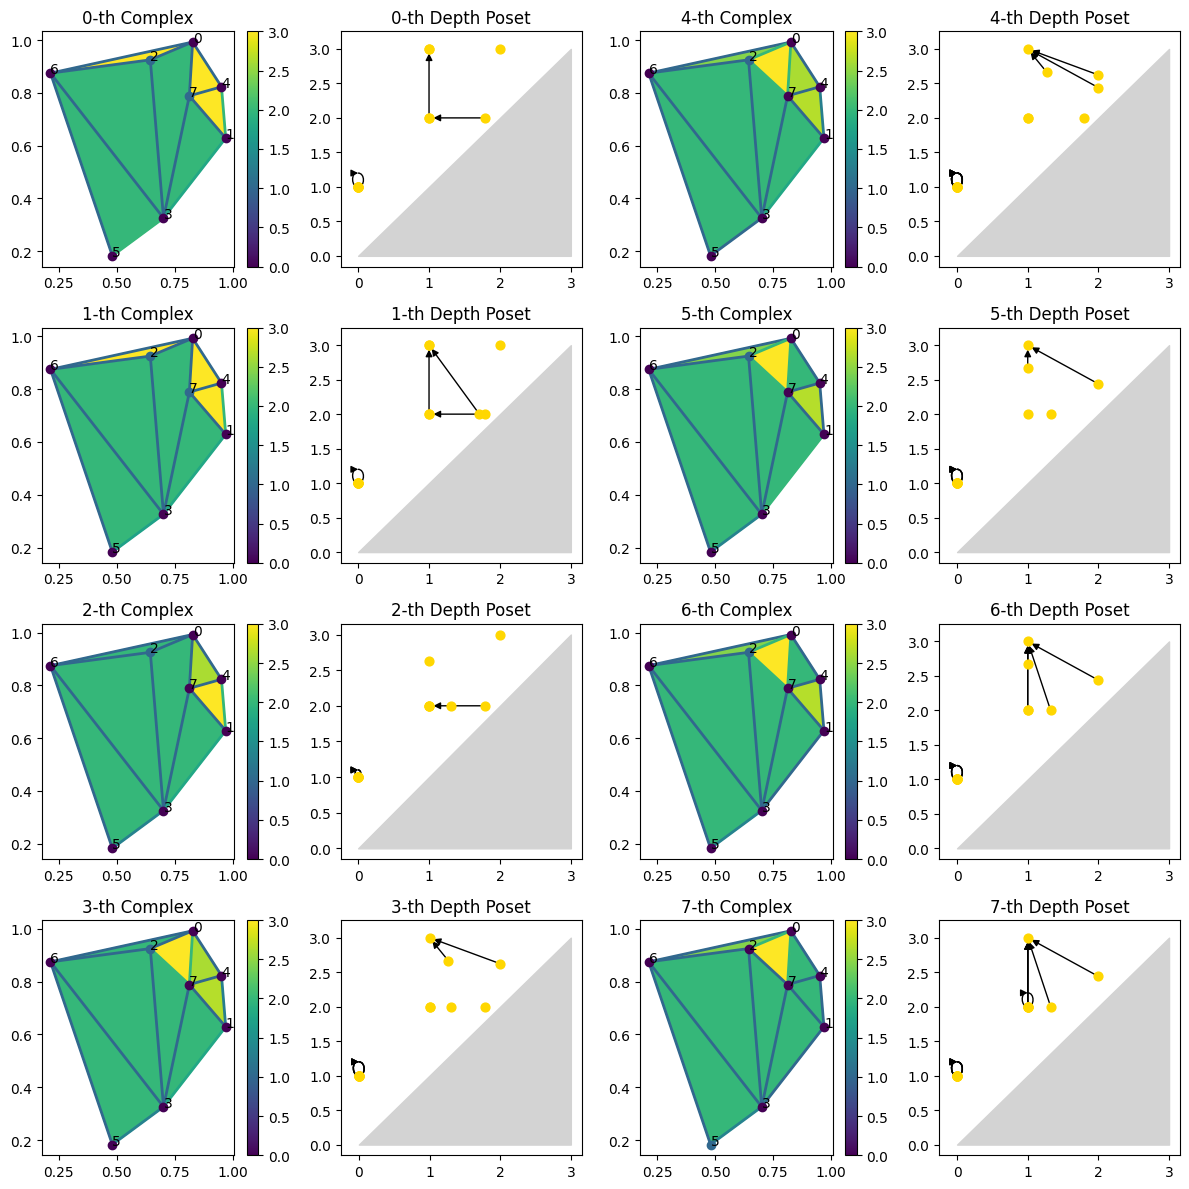

In [49]:
n_rows = int(np.ceil(0.5*n_filtrations))
fig, axs = plt.subplots(n_rows, 4, figsize=(12, n_rows*3))

for i in tqdm(range(n_filtrations), total=n_filtrations):
    i_row = i%n_rows
    i_col = i//n_rows*2
    
    axs[i_row, i_col + 0].set_title(f'{i}-th Complex')
    sm = plot_filtred_complex2d(strees[i], points, ax=axs[i_row, i_col + 0])
    plt.colorbar(sm, ax=axs[i_row, i_col + 0])
    enumerate_points(points, ax=axs[i_row, i_col + 0])
    
    axs[i_row, i_col + 1].set_title(f'{i}-th Depth Poset')
    nx.draw_networkx(dps[i].get_transitive_closure(), dps[i].persistant_layout(), 
                     node_color='gold', node_size=40, with_labels=False,
                     ax=axs[i_row, i_col + 1], hide_ticks=False)
    axs[i_row, i_col + 1].fill_between([filtrations[i].min(), filtrations[i].max()],
                                       [filtrations[i].min(), filtrations[i].min()],
                                       [filtrations[i].min(), filtrations[i].max()],
                                       color='lightgrey')

plt.tight_layout()
plt.savefig('pics/Comparing Filtrations - complexes and depth posets.png')

## Apply Scores

In [50]:
scores_list = [jacard_cells, 
               jacard_nodes_cells, 
               jacard_edges_cells, 
               jacard_nodes_bd_index, 
               jacard_edges_bd_index, 
               hausdorff_nodes_bd_index, 
               hausdorff_edges_bd_index, 
               jacard_nodes_bd_values, 
               jacard_edges_bd_values, 
               hausdorff_nodes_bd_values, 
               hausdorff_edges_bd_values, 
               density_distance, 
              ]
len(scores_list)

12

In [51]:
cdists = np.nan*np.empty([len(scores_list), n_filtrations, n_filtrations], dtype=float)

with tqdm(total=np.prod(cdists.shape)) as pbar:
    for i, j in itertools.product(range(n_filtrations), repeat=2):
        dpi, dpj = dps[i], dps[j]
        streei, streej = strees[i], strees[j]
        for i_score, score in enumerate(scores_list):
            try:
                value = score(streei, streej, dpi, dpj)
            except TypeError:
                value = score(dpi, dpj)
            cdists[i_score, i, j] = value
            pbar.update()

  0%|          | 0/768 [00:00<?, ?it/s]

/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:228: RuntimeWarning: invalid value encountered in divide
  t = d0_cross_d2 / d1_cross_d2
/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:229: RuntimeWarning: invalid value encountered in divide
  u = cross(b0 - a0, d1) / d1_cross_d2
/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:228: RuntimeWarning: divide by zero encountered in divide
  t = d0_cross_d2 / d1_cross_d2
/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:229: RuntimeWarning: divide by zero encountered in divide
  u = cross(b0 - a0, d1) / d1_cross_d2


In [52]:
assert (cdists.transpose([0, 2, 1]) == cdists).all()

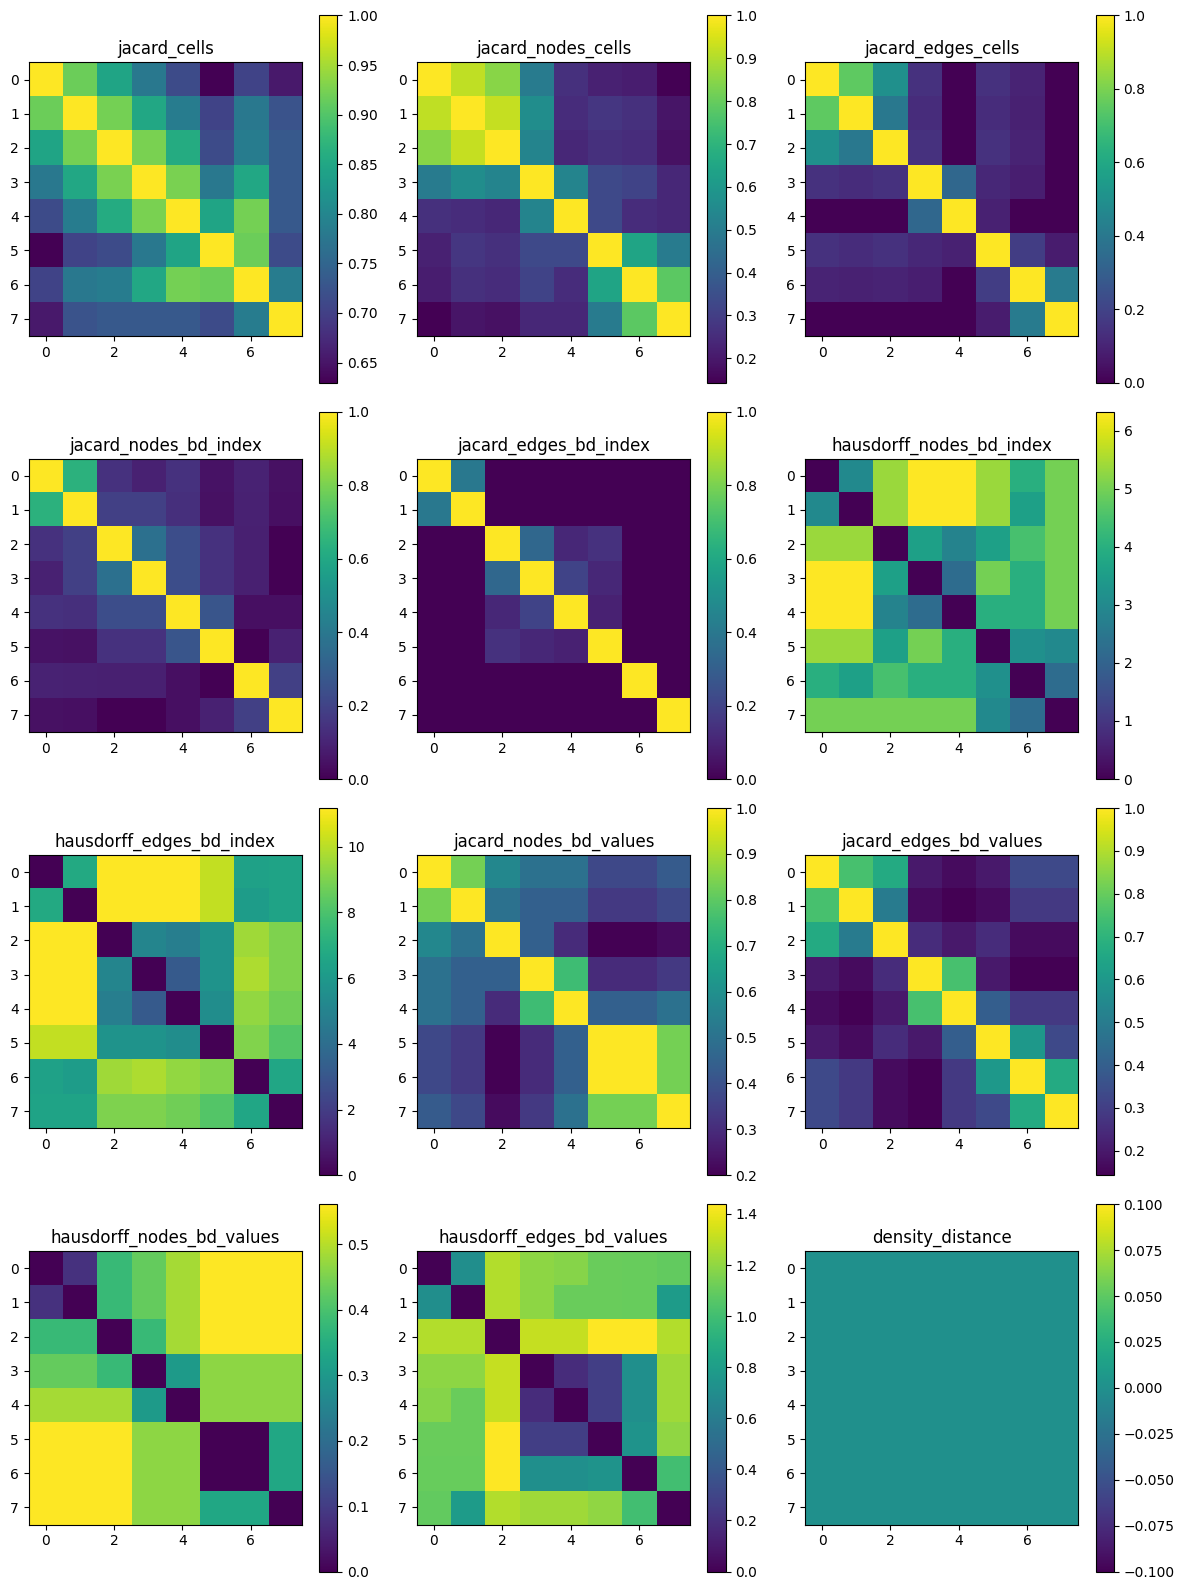

In [53]:
n_elements = len(scores_list)# + 2
n_cols = int(np.ceil(n_elements**0.5))
n_rows = int(np.ceil(n_elements/n_cols))


fig, axs = plt.subplots(n_cols, n_rows, figsize=(4*n_rows, 4*n_cols))

for i_score, score in enumerate(scores_list):
    i_row = i_score//n_rows
    i_col = i_score%n_rows

    axs[i_row, i_col].set_title(score.__name__)
    sm = axs[i_row, i_col].imshow(cdists[i_score])
    plt.colorbar(sm, ax=axs[i_row, i_col])

plt.tight_layout()
plt.savefig('pics/Comparing Filtrations - scores.png')

## Checking the Dependicies

### Compare just Distances between Filtrations

In [54]:
from sortedcontainers import SortedList

def count_inversions(arr):
    """Counts the number of inversions in the given array using a SortedList."""
    inversions = 0
    sorted_list = SortedList()
    for num in arr:
        # Count how many numbers in sorted_list are greater than num
        inversions += len(sorted_list) - sorted_list.bisect_right(num)
        sorted_list.add(num)
    return inversions

def transpositions_needed(arr1, arr2):
    """
    Computes the number of adjacent transpositions needed 
    to transform arr1 into arr2.
    
    Parameters:
        arr1, arr2: Two NumPy arrays containing the same elements in different orders.
    
    Returns:
        Number of transpositions (inversions) needed.
    """
    if set(arr1) != set(arr2):
        raise ValueError("Both arrays must contain the same elements in a different order.")

    # Map arr2 into the rank order of arr1
    rank_map = {value: i for i, value in enumerate(arr2)}
    arr1_mapped = np.array([rank_map[x] for x in arr1])

    # Count transpositions
    return count_inversions(arr1_mapped)

# Example usage
a = np.array([3, 1, 2, 4])
b = np.array([1, 2, 3, 4])

print("Number of transpositions:", transpositions_needed(a, b))


Number of transpositions: 2


In [55]:
filtrations_rank_transpositions = np.nan*np.zeros([n_filtrations, n_filtrations])
for (i, filtration_i), (j, filtration_j) in itertools.product(enumerate(filtrations_rank), repeat=2):
    filtrations_rank_transpositions[i, j] = transpositions_needed(filtration_i, filtration_j)

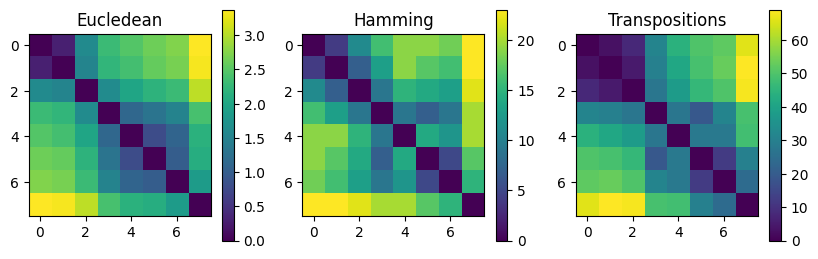

In [56]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

axs[0].set_title('Eucledean')
sm = axs[0].imshow(filtrations_distances)
plt.colorbar(sm, ax=axs[0])

axs[1].set_title('Hamming')
sm = axs[1].imshow(filtrations_rank_distances)
plt.colorbar(sm, ax=axs[1])

axs[2].set_title('Transpositions')
sm = axs[2].imshow(filtrations_rank_transpositions)
plt.colorbar(sm, ax=axs[2])

plt.show()

In [57]:
triu = np.triu(np.ones([n_filtrations, n_filtrations], dtype=bool))

df_distances = pd.DataFrame({'Eucledean': filtrations_distances[triu], 
                             'Hamming': filtrations_rank_distances[triu], 
                             'Transpositions': filtrations_rank_transpositions[triu]
                            }, 
                            index=map(tuple, np.array(np.where(triu)).transpose())
                           )
print(f'df_distances.shape = {df_distances.shape}')
df_distances.head()

df_distances.shape = (36, 3)


,Eucledean,Hamming,Transpositions
"(0, 0)",0.000000,0.0,0.0
"(0, 1)",0.290130,4.0,3.0
"(0, 2)",1.620091,11.0,8.0
"(0, 3)",2.296517,16.0,31.0
"(0, 4)",2.471226,19.0,44.0


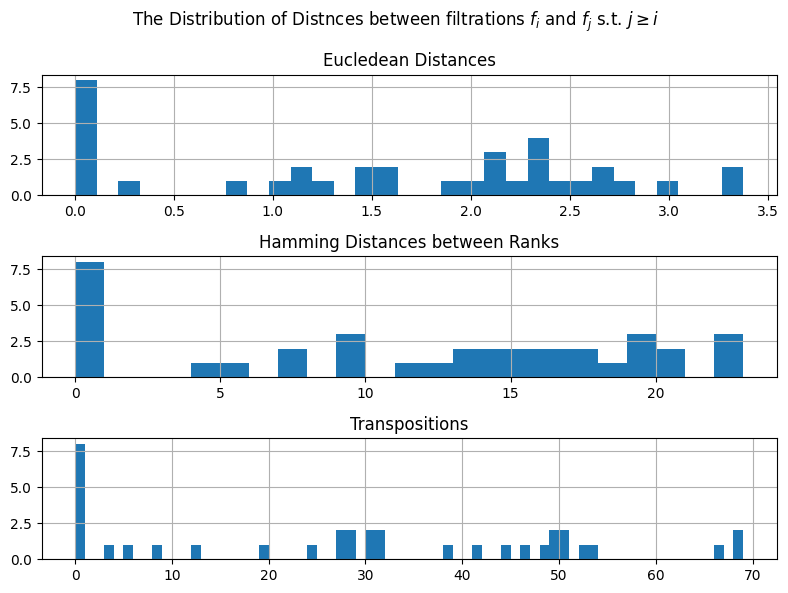

In [58]:
fig, axs = plt.subplots(3, figsize=(8, 6))

fig.suptitle(r'The Distribution of Distnces between filtrations $f_i$ and $f_j$ s.t. $j\geq i$')

axs[0].set_title(r'Eucledean Distances')
axs[0].hist(df_distances['Eucledean'], bins=len(simplices))
axs[0].grid(True)

axs[1].set_title(r'Hamming Distances between Ranks')
axs[1].hist(df_distances['Hamming'], bins=df_distances['Hamming'].max().astype(int))
axs[1].grid(True)

axs[2].set_title(r'Transpositions')
axs[2].hist(df_distances['Transpositions'], bins=df_distances['Transpositions'].max().astype(int))
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [59]:
# Pearson correlation
df_distance_pearson = []

for col0, col1 in itertools.combinations(df_distances.columns, 2):
    corr, p_value = stats.pearsonr(df_distances[col0], df_distances[col1])
    df_distance_pearson.append({'distances': (col0, col1), 
                                'correlation': corr, 
                                'p-value': p_value})

df_distance_pearson = pd.DataFrame(df_distance_pearson)
df_distance_pearson

,distances,correlation,p-value
0,"(Eucledean, Hamming)",0.949391,1.133557e-18
1,"(Eucledean, Transpositions)",0.933322,1.086534e-16
2,"(Hamming, Transpositions)",0.932838,1.224275e-16


### The Scores Distribution

In [60]:
df_score_values = pd.DataFrame({score.__name__: cdists[i_score, triu] for i_score, score in enumerate(scores_list)}, 
                               index=map(tuple, np.array(np.where(triu)).transpose())
                        )
print(f'df_score_values.shape = {df_score_values.shape}')
df_score_values.head()

df_score_values.shape = (36, 12)


,jacard_cells,jacard_nodes_cells,jacard_edges_cells,jacard_nodes_bd_index,jacard_edges_bd_index,hausdorff_nodes_bd_index,hausdorff_edges_bd_index,jacard_nodes_bd_values,jacard_edges_bd_values,hausdorff_nodes_bd_values,hausdorff_edges_bd_values,density_distance
"(0, 0)",1.000000,1.000000,1.000000,1.000000,1.0,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000,0.0
"(0, 1)",0.916667,0.916667,0.750000,0.642857,0.4,3.000000,6.78233,0.833333,0.750000,0.080931,0.709870,0.0
"(0, 2)",0.846154,0.846154,0.500000,0.142857,0.0,5.385165,11.18034,0.571429,0.666667,0.377503,1.274898,0.0
"(0, 3)",0.777778,0.500000,0.142857,0.090909,0.0,6.324555,11.18034,0.500000,0.200000,0.427963,1.196356,0.0
"(0, 4)",0.714286,0.263158,0.000000,0.142857,0.0,6.324555,11.18034,0.500000,0.166667,0.485948,1.177923,0.0


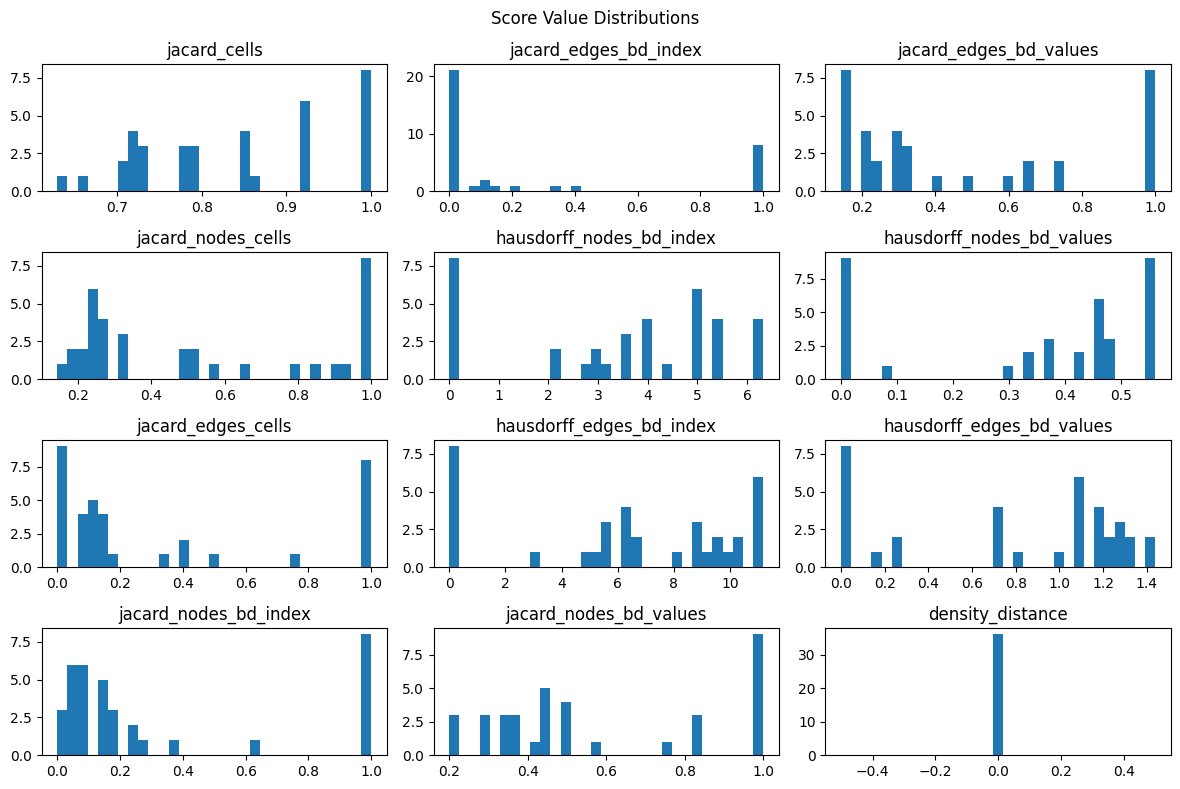

In [61]:
n_rows = int(np.ceil(0.3*df_score_values.shape[1]))
n_cols = int(np.ceil(df_score_values.shape[1]/n_rows))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*2))
fig.suptitle('Score Value Distributions')

for i in range(n_rows*n_cols):
    i_row = i%n_rows
    i_col = i//n_rows
    if i < df_score_values.shape[1]:
        col = df_score_values.columns[i]
        axs[i_row, i_col].set_title(col)
        axs[i_row, i_col].hist(df_score_values[col], bins=len(simplices))
    else:
        axs[i_row, i_col].set_xticks([])
        axs[i_row, i_col].set_yticks([])
plt.tight_layout()
plt.show()

### Comparing Distances and Scores

In [62]:
df_distance_score_pearson = []
for distance in df_distances.columns:
    for score in df_score_values.columns:
        corr, p_value = stats.pearsonr(df_distances[distance], df_score_values[score])
        df_distance_score_pearson.append({'distance': distance, 
                                          'score': score, 
                                          'correlation': corr, 
                                          'p-value': p_value,
                                         })

df_distance_score_pearson = pd.DataFrame(df_distance_score_pearson)
df_distance_score_pearson = df_distance_score_pearson.pivot(index='score', columns='distance', values=['correlation', 'p-value'])

print(f'df_distance_score_pearson.shape = {df_distance_score_pearson.shape}')
df_distance_score_pearson

df_distance_score_pearson.shape = (12, 6)


/tmp/ipykernel_111445/1539608274.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = stats.pearsonr(df_distances[distance], df_score_values[score])


correlation                                p-value  \
distance                    Eucledean   Hamming Transpositions     Eucledean   
score                                                                          
density_distance                  NaN       NaN            NaN           NaN   
hausdorff_edges_bd_index     0.727807  0.712767       0.565966  4.910855e-07   
hausdorff_edges_bd_values    0.839890  0.783735       0.697751  1.515172e-10   
hausdorff_nodes_bd_index     0.819544  0.803955       0.692434  9.804110e-10   
hausdorff_nodes_bd_values    0.901877  0.893901       0.883950  6.043694e-14   
jacard_cells                -0.913507 -0.919552      -0.877557  7.756814e-15   
jacard_edges_bd_index       -0.843392 -0.843910      -0.741072  1.070351e-10   
jacard_edges_bd_values      -0.854119 -0.838834      -0.820305  3.494742e-11   
jacard_edges_cells          -0.864181 -0.881430      -0.843010  1.124720e-11   
jacard_nodes_bd_index       -0.863626 -0.857578      -0.785677  1.200087e-11   
jacard_nodes_bd_values      -0.805152 -0.766915      -0.811751  3.208992e-09   
jacard_nodes_cells          -0.848173 -0.878746      -0.927161  6.568829e-11   

                                                        
distance                        Hamming Transpositions  
score                                                   
density_distance                    NaN            NaN  
hausdorff_edges_bd_index   1.076188e-06   3.211226e-04  
hausdorff_edges_bd_values  1.580989e-08   2.246141e-06  
hausdorff_nodes_bd_index   3.525886e-09   2.884018e-06  
hausdorff_nodes_bd_values  2.142540e-13   9.086774e-13  
jacard_cells               2.373521e-15   2.148610e-12  
jacard_edges_bd_index      1.016006e-10   2.353117e-07  
jacard_edges_bd_values     1.679781e-10   9.181190e-10  
jacard_edges_cells         1.283263e-12   1.112189e-10  
jacard_nodes_bd_index      2.389991e-11   1.378417e-08  
jacard_nodes_bd_values     4.904416e-08   1.886477e-09  
jacard_nodes_cells         1.837547e-12   4.653037e-16

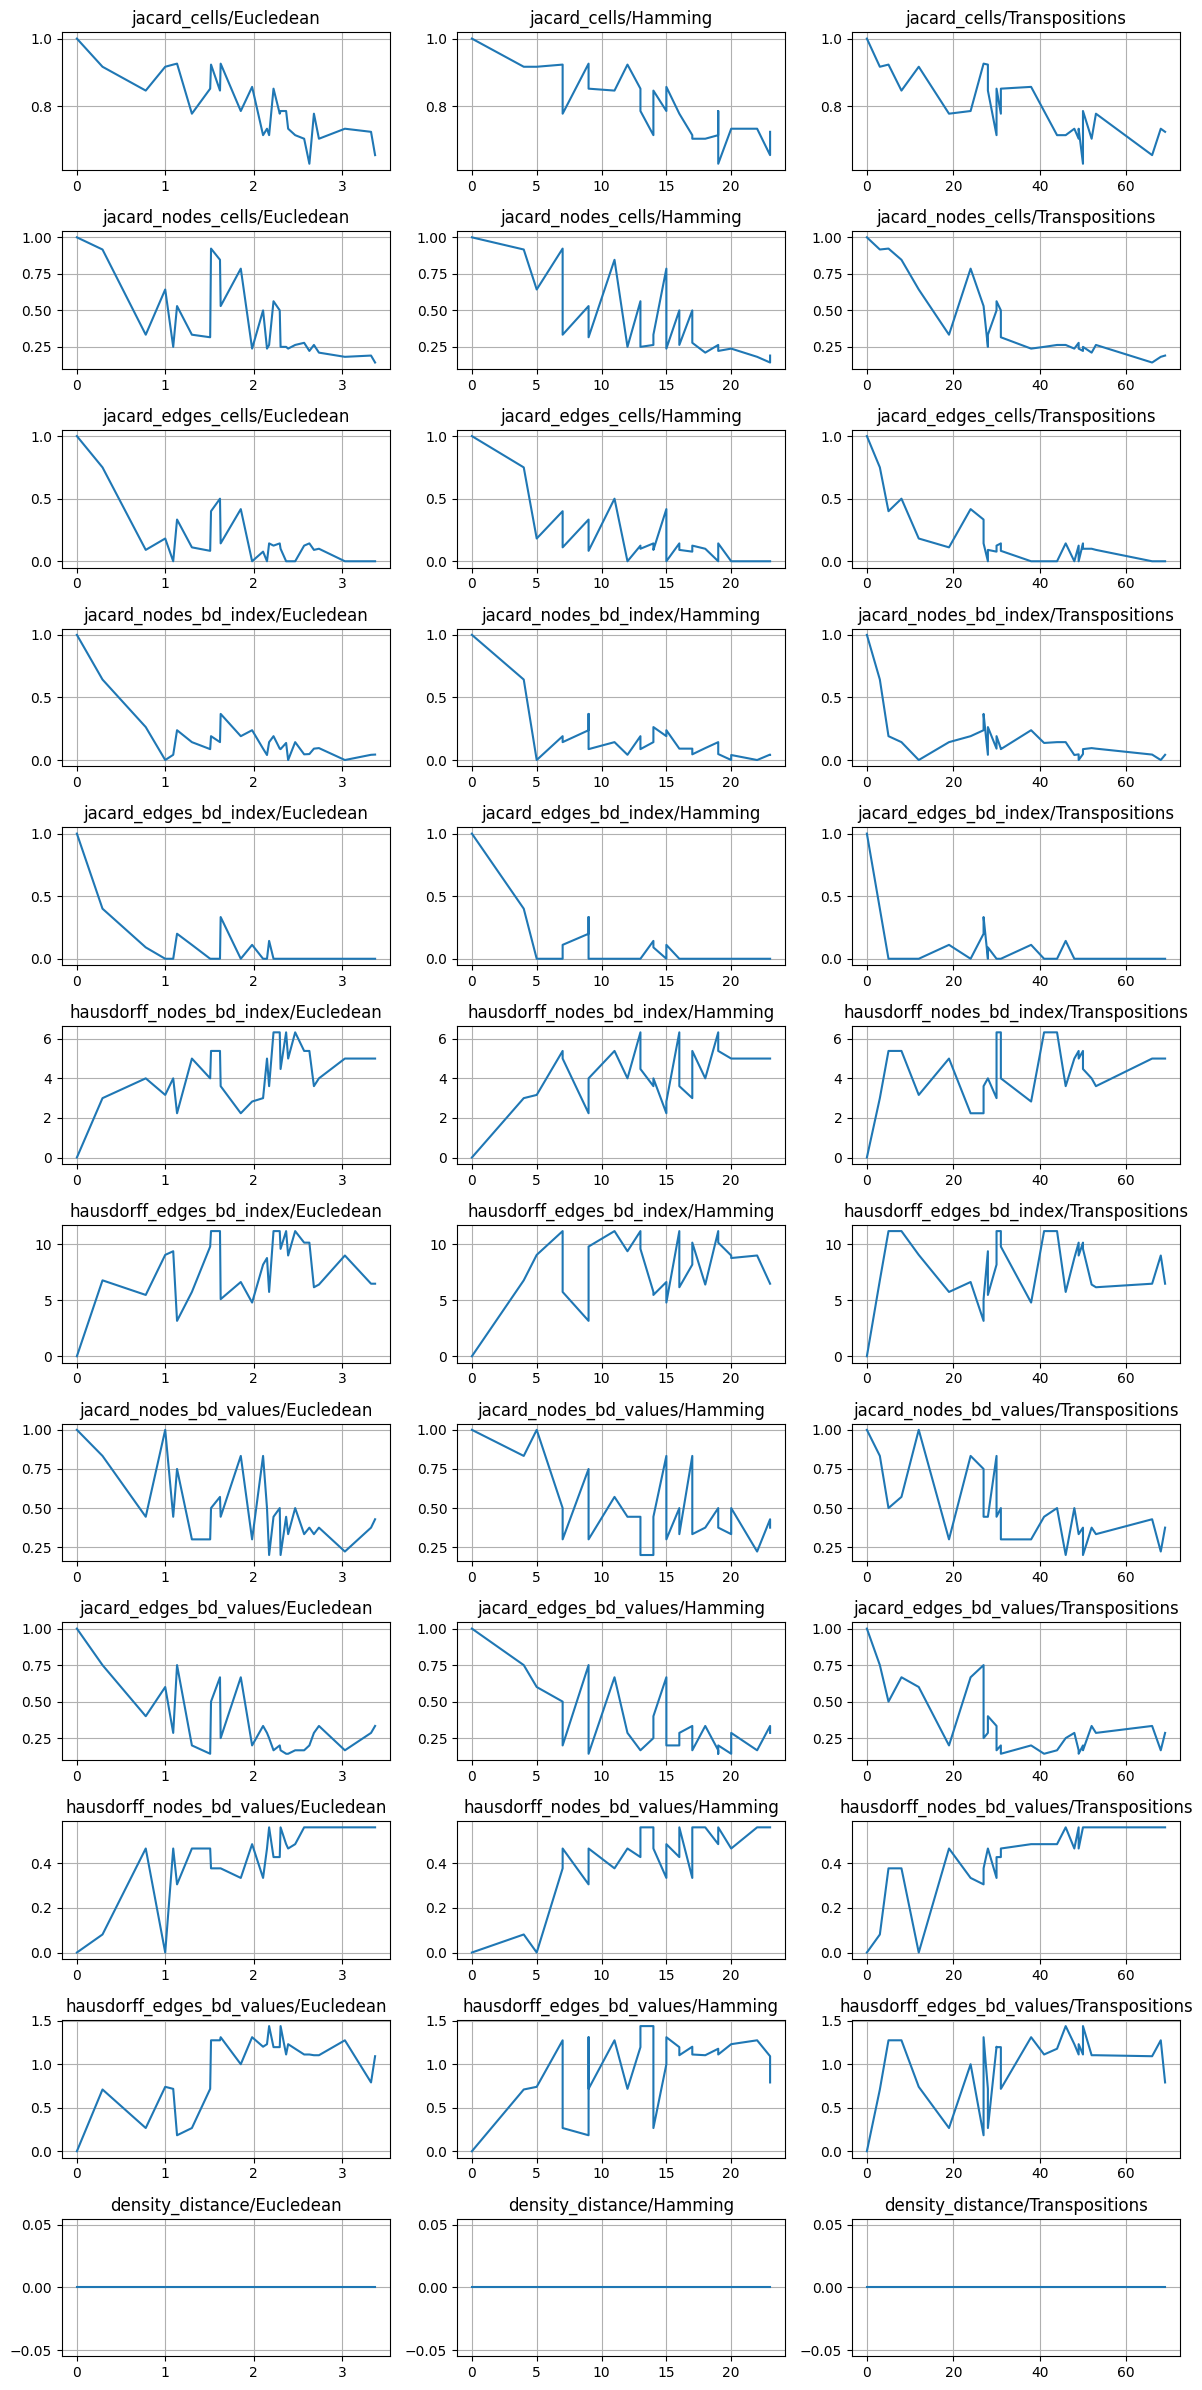

In [63]:
fig, axs = plt.subplots(df_score_values.shape[1], df_distances.shape[1], figsize=(4*df_distances.shape[1], 2*df_score_values.shape[1]))

for i_score, score in enumerate(df_score_values.columns):
    for i_distance, distance in enumerate(df_distances.columns):
        axs[i_score, i_distance].set_title(f'{score}/{distance}')

        x = np.sort(df_distances[distance].values)
        y = df_score_values[score].values[df_distances[distance].values.argsort()]
        axs[i_score, i_distance].plot(x, y)
        axs[i_score, i_distance].grid(True)
plt.tight_layout()
plt.show()

# Homothopy Between 2 Filtrations 

In [64]:
import imageio as io
from PIL import Image

In [65]:
def assign_filtration(stree: gh.SimplexTree, filtration):
    # returns the SimplexTree with the given filtration
    stree_res = gh.SimplexTree()
    for (simplex, _), value in zip(stree.get_simplices(), filtration):
        stree_res.insert(simplex, value)
    return stree_res

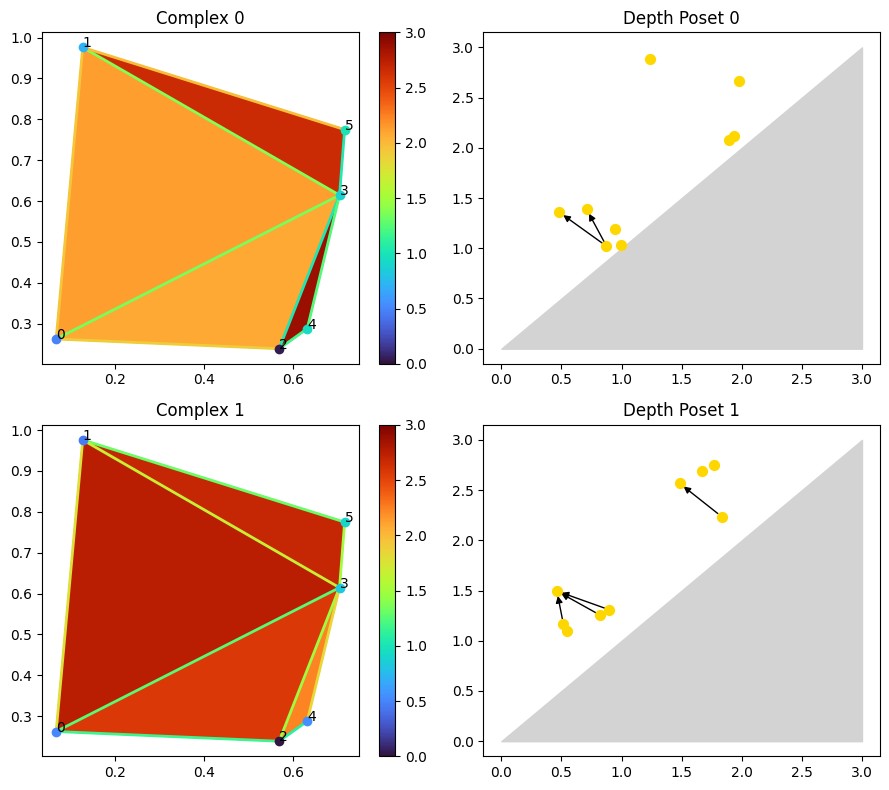

In [66]:
n = 6
dim = 2
points = np.random.random([n, dim])

stree0 = gh.AlphaComplex(points).create_simplex_tree()
simplex_dimensions = np.array([len(simplex) - 1 for simplex, _ in stree0.get_simplices()])

filtration0 = np.random.random(len(list(stree0.get_simplices()))) + simplex_dimensions
filtration1 = np.random.random(len(list(stree0.get_simplices()))) + simplex_dimensions

stree0 = assign_filtration(stree0, filtration0)
stree1 = assign_filtration(stree0, filtration1)


fig, axs = plt.subplots(2, 2, figsize=(9, 8))
for i, streei in enumerate([stree0, stree1]):
    axs[i, 0].set_title(f'Complex {i}')
    sm = plot_filtred_complex2d(streei, points, ax=axs[i, 0], cmap='turbo', vmin=0, vmax=dim+1)
    plt.colorbar(sm, ax=axs[i, 0])
    enumerate_points(points, ax=axs[i, 0])

    axs[i, 1].set_title(f'Depth Poset {i}')
    dp = DepthPoset.from_simplex_tree(streei)
    nx.draw_networkx(dp.get_transitive_reduction(), pos=dp.persistant_layout(), ax=axs[i, 1], 
                     node_color='gold', node_size=50, with_labels=False, hide_ticks=False)
    axs[i, 1].fill_between([0, dim + 1], [0, 0], [0, dim + 1], color='lightgrey')

plt.tight_layout()
plt.show()

In [67]:
ts = np.linspace(0, 1, 401)

imgs = []
for it, t in tqdm(enumerate(ts), total=len(ts)):
    filtration = (1 - t)*filtration0 + t*filtration1
    stree = assign_filtration(stree0, filtration)
    dp = DepthPoset.from_simplex_tree(stree)

    fig, axs = plt.subplots(1, 2)
    fig.suptitle(f'$t = {t:.4f}$')

    axs[0].set_title(f'Filtration on Complex')
    sm = plot_filtred_complex2d(streei, points, ax=axs[0], cmap='turbo', vmin=0, vmax=dim+1)
    plt.colorbar(sm, ax=axs[0])
    enumerate_points(points, ax=axs[0])

    axs[1].set_title(f'Depth Poset')
    nx.draw_networkx(dp.get_transitive_reduction(), pos=dp.persistant_layout(), ax=axs[1], 
                     node_color='gold', node_size=50, with_labels=False, hide_ticks=False)
    axs[1].fill_between([0, dim + 1], [0, 0], [0, dim + 1], color='lightgrey')

    plt.tight_layout()

    # draw, save, close and delete
    fig.canvas.draw()
    width, height = fig.canvas.get_width_height()
    image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8').reshape(height, width, 4)
    img = Image.fromarray(image[..., :3])  # отбрасываем альфа-канал

    imgs.append(img)
    plt.close('all')
    del fig

filename = f'gifs/2-filtrations-homotopy.gif'

io.mimsave(filename, imgs, fps=12, loop=0)
print(f'generated and saved to path {filename}')

  0%|          | 0/401 [00:00<?, ?it/s]

generated and saved to path gifs/2-filtrations-homotopy.gif
